In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from sklearn.preprocessing import OrdinalEncoder
# import dataprep.eda.create_report as report
import seaborn as sns
import matplotlib.pyplot as plt

# 1.Loading Data

In [87]:
df=pd.read_csv("sensor_data.csv")
df.head()

,Timestamp,Boiler Name,Temperature,Anomaly
0,2023-01-23 00:58:20,Boiler A,20.180428,0
1,2023-01-30 06:30:08,Boiler A,23.372948,0
2,2023-01-03 10:47:23,Boiler A,29.858208,0
3,2023-01-03 17:10:50,Boiler C,20.564032,0
4,2023-01-04 17:50:22,Boiler D,23.547024,0


# 2.Exploring data

In [73]:
le=df[df['Anomaly']==1]
le.shape

(24, 4)

In [74]:
df.dtypes #data types

Timestamp       object
Boiler Name     object
Temperature    float64
Anomaly          int64
dtype: object

In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].apply(lambda x : x.year)
df['month'] = df['Timestamp'].apply(lambda x : x.month)
df['day'] = df['Timestamp'].apply(lambda x : x.day)
df['hour'] = df['Timestamp'].apply(lambda x : x.hour)
df['minute'] = df['Timestamp'].apply(lambda x : x.minute)

df

,Timestamp,Boiler Name,Temperature,Anomaly,year,month,day,hour,minute
0,2023-01-23 00:58:20,Boiler A,20.180428,0,2023,1,23,0,58
1,2023-01-30 06:30:08,Boiler A,23.372948,0,2023,1,30,6,30
2,2023-01-03 10:47:23,Boiler A,29.858208,0,2023,1,3,10,47
3,2023-01-03 17:10:50,Boiler C,20.564032,0,2023,1,3,17,10
4,2023-01-04 17:50:22,Boiler D,23.547024,0,2023,1,4,17,50
...,...,...,...,...,...,...,...,...,...
995,2023-01-11 23:39:44,Boiler A,27.596447,0,2023,1,11,23,39
996,2023-01-25 01:22:21,Boiler B,19.189359,0,2023,1,25,1,22
997,2023-01-02 03:47:51,Boiler A,17.157156,0,2023,1,2,3,47
998,2023-01-07 09:21:22,Boiler B,23.135241,0,2023,1,7,9,21


# 3.Data Visualization

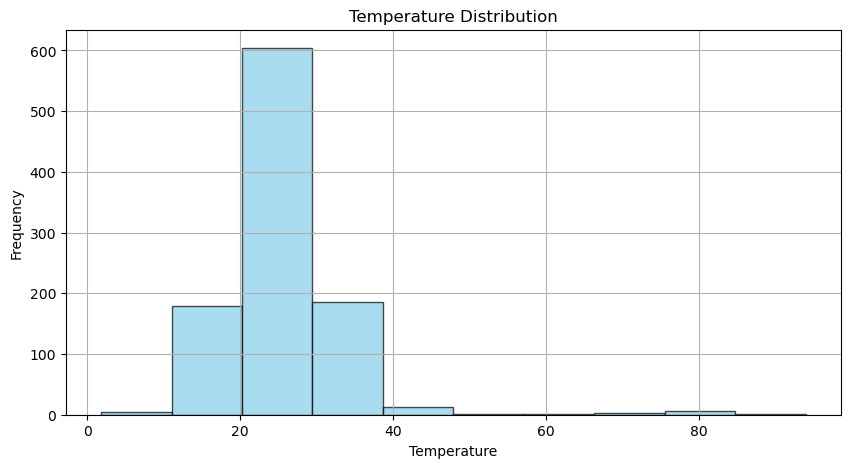

In [75]:
plt.figure(figsize=(10, 5))
plt.hist(df['Temperature'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


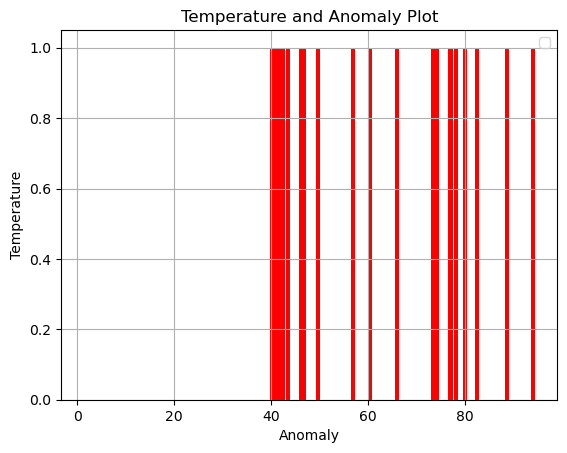

In [76]:
plt.bar(df['Temperature'],df['Anomaly'], color='red')

plt.xlabel('Anomaly')
plt.ylabel('Temperature')
plt.title('Temperature and Anomaly Plot')
plt.legend()
plt.grid(True)
plt.show()

# 4.Checking For Null Values

In [77]:
df.shape

(1000, 4)

In [78]:
df.isnull().sum() 

Timestamp      0
Boiler Name    0
Temperature    0
Anomaly        0
dtype: int64

In [79]:
df.describe() #see statistics of data

,Temperature,Anomaly
count,1000.000000,1000.000000
mean,25.795237,0.024000
std,8.206830,0.153126
min,1.793127,0.000000
25%,21.847202,0.000000
50%,25.120639,0.000000
75%,28.567648,0.000000
max,94.007501,1.000000


In [80]:
# check no of rows (records) of each 1 and 0 in dataframe
df['Anomaly'].value_counts()

Anomaly
0    976
1     24
Name: count, dtype: int64

In [9]:
grouped_data = df.groupby([df['year'], df['month']]).size()
grouped_data

year  month
2023  1        1000
dtype: int64

# 5.Check Outliers

In [21]:
#remove outliers 
#Clip the particular datas between upper and lower threshold
def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper = df[column].quantile(0.75) + (1.5*iqr)
    lower = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower, upper)

In [22]:
outlier(df, 'Temperature')

In [23]:
def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

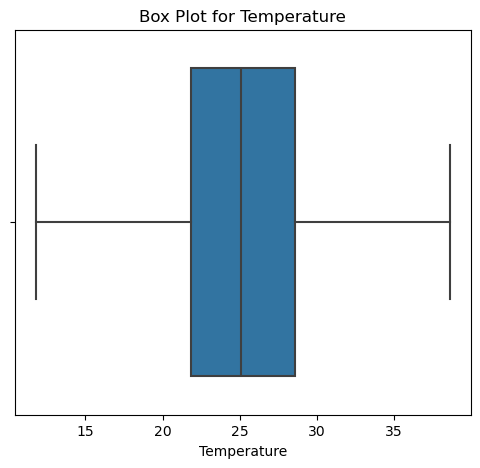

In [24]:
for i in ['Temperature']:
    plot(df, i)

# 6. Predicting Anomaly based on Z-Score

In [81]:
# Calculate Z-score
df['z_score'] = (df['Temperature'] - df['Temperature'].mean()) / df['Temperature'].std()

# Define threshold for anomaly detection
threshold = 2   #set threshold=2

# Detect anomalies
df['Anomaly'] = np.where(np.abs(df['z_score']) > threshold, True, False)

anomalies = df[df['z_score'] > 2]
anomalies.shape

(19, 5)

In [82]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calculate mean and standard deviation of temperature
mean_temp = df['Temperature'].mean()
std_temp = df['Temperature'].std()

# Calculate Z-scores
df['z_score'] = (df['Temperature'] - mean_temp) / std_temp

# Set threshold (e.g., 2 standard deviations)
threshold = 2

# Label anomalies based on threshold
df['predicted_label'] = df['z_score'].apply(lambda x: 1 if x > threshold else 0)

# Evaluate performance
true_labels = df['Anomaly']
predicted_labels = df['predicted_label']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

Confusion Matrix:
[[978   0]
 [  3  19]]
Precision: 1.0
Recall: 0.8636363636363636
F1 Score: 0.926829268292683


In [15]:
# scaling X here 
#Importing the ROBUST SCALER
from sklearn.preprocessing import RobustScaler
x=df.drop(['Timestamp'],axis=1)
# Using the robust scaler 
robust_scaler_1 = RobustScaler()
X = robust_scaler_1.fit_transform(x)
X = pd.DataFrame(X)

#After scaling data be like 
print(X.head())

     0         1    2    3    4         5         6         7         8    9
0 -1.0 -0.735101  0.0  0.0  0.0  0.533333 -0.916667  0.950000 -0.735101  0.0
1 -1.0 -0.260056  0.0  0.0  0.0  1.000000 -0.416667  0.016667 -0.260056  0.0
2 -1.0  0.704949  0.0  0.0  0.0 -0.800000 -0.083333  0.583333  0.704949  0.0
3  0.0 -0.678021  0.0  0.0  0.0 -0.800000  0.500000 -0.650000 -0.678021  0.0
4  0.5 -0.234153  0.0  0.0  0.0 -0.733333  0.500000  0.683333 -0.234153  0.0


# 7.Converting Categorical to Numerical

In [45]:
df['Boiler Name'].unique()

array(['Boiler A', 'Boiler C', 'Boiler D', 'Boiler B'], dtype=object)

In [88]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform categories
df['Boiler Name'] = label_encoder.fit_transform(df[['Boiler Name']])


In [84]:
df

,Timestamp,Boiler Name,Temperature,Anomaly,z_score,predicted_label
0,2023-01-23 00:58:20,0,20.180428,False,-0.684163,0
1,2023-01-30 06:30:08,0,23.372948,False,-0.295155,0
2,2023-01-03 10:47:23,0,29.858208,False,0.495072,0
3,2023-01-03 17:10:50,2,20.564032,False,-0.637421,0
4,2023-01-04 17:50:22,3,23.547024,False,-0.273944,0
...,...,...,...,...,...,...
995,2023-01-11 23:39:44,0,27.596447,False,0.219477,0
996,2023-01-25 01:22:21,1,19.189359,False,-0.804924,0
997,2023-01-02 03:47:51,0,17.157156,False,-1.052548,0
998,2023-01-07 09:21:22,1,23.135241,False,-0.324120,0


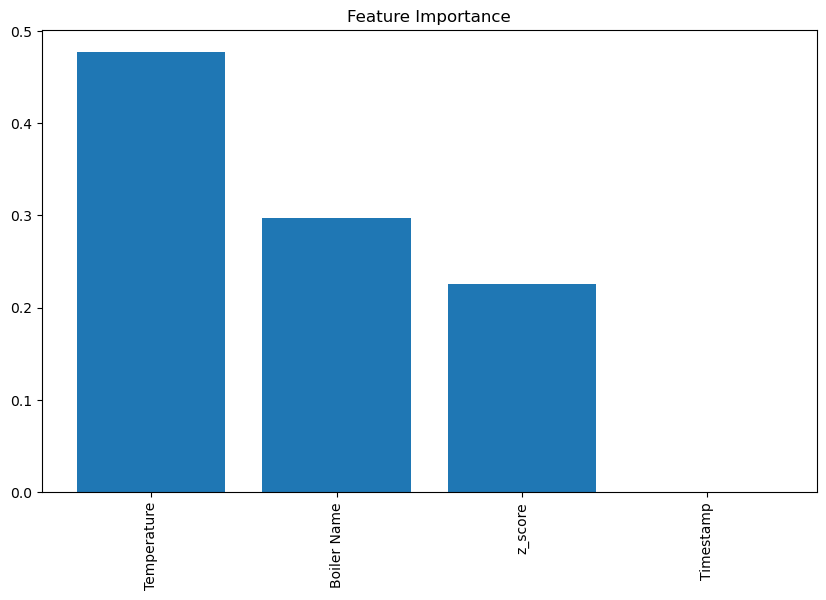

In [85]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
x= df.drop('Timestamp',axis=1)
x= x.drop('predicted_label',axis=1)
y = df['Anomaly']



feature_names = ['Timestamp','Boiler Name', 'Temperature','z_score','predicted_label']
      

# Train a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x, y)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names based on feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(x.shape[1]), importances[indices])
plt.xticks(range(x.shape[1]), names, rotation=90)
plt.show()

# 8.Model selection and implementation

In [107]:
# Load the dataset
x= df.drop('Timestamp',axis=1)
x=x.drop('label',axis=1)
x=x.drop('Anomaly',axis=1)
y = df['Anomaly']
x

,Boiler Name,Temperature
0,0,20.180428
1,0,23.372948
2,0,29.858208
3,2,20.564032
4,3,23.547024
...,...,...
995,0,27.596447
996,1,19.189359
997,0,17.157156
998,1,23.135241


In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Labeling data based on threshold
threshold = 40
df['label'] = (df['Temperature'] > threshold).astype(int)

# # Splitting data into features (X) and labels (y)
# X = df[['Temperature']]
# y = df['Anomaly']

x= df.drop('Timestamp',axis=1)
x=x.drop('label',axis=1)
x=x.drop('Anomaly',axis=1)
y = df['Anomaly']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.995
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


In [123]:
def classify_temperature(model, name,temperature):
    # Convert temperature to DataFrame with the same format as training data
    new_data = pd.DataFrame({'Boiler Name':[name],'Temperature': [temperature]})
    # Predict the label for the new temperature using the trained model
    prediction = model.predict(new_data)
    # Return the prediction
    return prediction

new_temperature = 23.5
boiler_name=1

prediction = classify_temperature(model,boiler_name,new_temperature)

if prediction == 0:
    print(f"The temperature {new_temperature} degrees Celsius is classified as normal.")
else:
    print(f"The temperature {new_temperature} degrees Celsius is classified as abnormal.")

The temperature 23.5 degrees Celsius is classified as normal.


In [124]:
# save the regression model by using pickle
import pickle
with open('anomaly_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [126]:
# load the pickle model to predict selling price
import pickle
with open('anomaly_model.pkl', 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(np.array([[1,81]]))
y_pred[0]

1

In [65]:
from sklearn.svm import OneClassSVM
threshold = 40
normal_data = df[df['Temperature'] <= threshold]

# Train One-Class SVM model
model = OneClassSVM(kernel='rbf', nu=0.1)  # Adjust parameters as needed
model.fit(normal_data[['Temperature']])

# Predict anomalies (temperatures above threshold)
anomalies = df[df['Temperature'] > threshold]
predictions = model.predict(anomalies[['Temperature']])

# Print the predicted anomalies
print("Predicted anomalies:")
print(anomalies[predictions == -1])

Predicted anomalies:
               Timestamp  Boiler Name  Temperature  Anomaly  label
60   2023-01-02 17:15:45            0    80.037748        1      1
81   2023-01-07 17:50:23            0    94.007501        1      1
117  2023-01-20 22:51:29            1    88.680524        1      1
118  2023-01-02 12:20:59            1    82.416402        1      1
138  2023-01-05 03:41:11            0    40.413956        1      1
144  2023-01-14 18:28:24            1    78.083391        1      1
195  2023-01-06 09:41:09            1    73.840947        1      1
317  2023-01-27 03:32:47            1    66.032211        1      1
384  2023-01-22 18:50:19            2    46.192764        1      1
457  2023-01-17 13:03:43            2    49.623586        1      1
506  2023-01-20 16:23:34            0    46.767853        1      1
519  2023-01-16 19:00:01            2    42.447662        1      1
541  2023-01-08 06:45:35            0    76.963407        1      1
645  2023-01-18 00:55:36            0    

In [66]:
from sklearn.metrics import accuracy_score

# Assuming 'model' is the trained One-Class SVM model and 'X_test', 'y_test' are the test data and labels
# Predict labels for the test data
y_pred = model.predict(X_test)

# Convert predicted labels to binary (1 for anomaly, -1 for normal)
y_pred_binary = (y_pred == -1).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Accuracy: 0.865


In [67]:
input_temperature = 55  # Example input temperature value

# Prepare the input data with the same format as the training data
input_data = pd.DataFrame({'Temperature': [input_temperature]})

# Use the trained model to predict whether the input data is normal or anomalous
prediction = model.predict(input_data[['Temperature']])[0]

# Check the predicted label to determine if the input data is classified as normal or anomalous
if prediction == -1:
    print(f"The input temperature {input_temperature} degrees Celsius is classified as anomalous.")
else:
    print(f"The input temperature {input_temperature} degrees Celsius is classified as normal.")

The input temperature 55 degrees Celsius is classified as anomalous.
